In [21]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import warnings
import numpy as np
import os

from torch import optim, nn
from torchvision import datasets, transforms, models
from skimage.segmentation import mark_boundaries
from helpers import *
from PIL import Image
from lime import lime_image


In [53]:
def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor


def predict(imagepath, model_path, verbose=False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        model = load_model(model_path)
    model.eval()
    #summary(model, input_size=(3,244,244))
    if verbose:
        print("Model Loaded..")
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    ps=torch.exp(model(image1))
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}
    

def image_transform_from_numpy(img_array):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.fromarray(np.uint8(img_array*255))
    imagetensor = test_transforms(image)
    return imagetensor

    
def model_to_lime(images):
    try:
        checks_if_model_is_loaded = type(model)
    except:
        model = load_model(model_path)
    model.eval()
    images = torch.stack([image_transform_from_numpy(x) for x in images])
    
    return torch.exp(model(images)).detach().numpy()


def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
inv_transform = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

In [9]:
dog_img_path = './data/dogs-vs-cats/test1/4.jpg'
cat_img_path = './data/dogs-vs-cats/test1/5.jpg'
model_path = './data/dogs-vs-cats/catvdog.pth'

{'class': 'dog', 'confidence': '0.9930562376976013'}


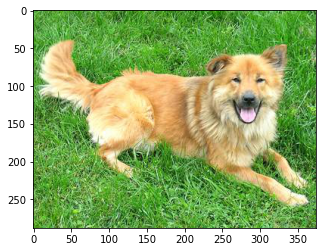

In [10]:
print(predict(dog_img_path, model_path))
plt.imshow(get_image(dog_img_path))

{'class': 'cat', 'confidence': '0.999834418296814'}


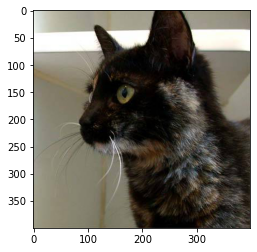

In [11]:
print(predict(cat_img_path, model_path))
plt.imshow(get_image(cat_img_path))

In [43]:
cat_img_array = np.array(get_image(cat_img_path))

explainer = lime_image.LimeImageExplainer()
explanation_cat = explainer.explain_instance(
    cat_img_array, 
    model_to_lime,
    top_labels=2,
    num_samples=1000
)

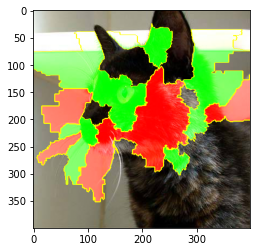

In [51]:
temp, mask = explanation_cat.get_image_and_mask(
    explanation_cat.top_labels[0], 
    positive_only=False, 
    num_features=30, 
    hide_rest=False
)
img_bound = mark_boundaries(temp/255.0, mask)
plt.imshow(img_bound)

In [56]:
dog_img_array = np.array(get_image(dog_img_path))

explainer = lime_image.LimeImageExplainer()
explanation_dog = explainer.explain_instance(
    dog_img_array, 
    model_to_lime,
    top_labels=2,
    num_samples=1000
)

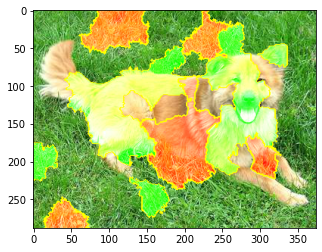

In [57]:
temp, mask = explanation_dog.get_image_and_mask(
    explanation_dog.top_labels[0], 
    positive_only=False, 
    num_features=30, 
    hide_rest=False
)
img_bound = mark_boundaries(temp/255.0, mask)
plt.imshow(img_bound)